In [1]:
import pickle as pkl
import os 
import sys
import numpy as np
from xopen import xopen
import json
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

def simMatrix(A: torch.tensor, B: torch.tensor) -> torch.tensor:
    # Assume A and B are your input tensors of shape (N, d)
    # Example: A = torch.randn(N, d)
    #          B = torch.randn(N, d)

    # Step 1: Normalize A and B
    A_norm = A / A.norm(dim=1, keepdim=True)
    B_norm = B / B.norm(dim=1, keepdim=True)

    # Step 2: Compute the dot product
    cosine_similarity_matrix = torch.mm(A_norm, B_norm.transpose(0, 1))

    # The resulting cosine_similarity_matrix is of shape (N, N)
    # and contains values in the range [-1, 1]
    return cosine_similarity_matrix

DATA_PATH = "/home/ubuntu/proj/data/graph/node_cora"
DATA_NAME = "text_graph_cora" # "text_graph_pubmed" #"text_graph_aids" #"text_graph_pubmed" # # 
TRAIN_SPLIT_NAME = 'train_index'
VALID_SPLIT_NAME = 'valid_index'
TEST_SPLIT_NAME = 'test_index'

with open(os.path.join(DATA_PATH, f"{DATA_NAME}.pkl"), 'rb') as f:
    graph = pkl.load(f)
with open(os.path.join(DATA_PATH, f"{TRAIN_SPLIT_NAME}.pkl"), 'rb') as f:
    train_split = pkl.load(f)

with open(os.path.join(DATA_PATH, f"{VALID_SPLIT_NAME}.pkl"), 'rb') as f:
    valid_split = pkl.load(f)
with open(os.path.join(DATA_PATH, f"{TEST_SPLIT_NAME}.pkl"), 'rb') as f:
    test_split = pkl.load(f)

k = 2


/home/ubuntu/anaconda3/envs/graphllm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_levels_embedding = dict()
encoder_type = 'angle'
for relevance_type in ['pos','neg','random_1','random_2','random_3']:
    all_levels_embedding[relevance_type] = dict()
    # build 0-order textual-graph
    text_nodes = graph.text_nodes
    edge_index = graph.edge_index
    k = 2
 
    for order in range(0, k+1):
        if encoder_type == 'bert':
            all_levels_embedding[relevance_type][order] = torch.load(os.path.join(DATA_PATH, relevance_type, f"order-{order}-bert.pt")).squeeze(-2)
        else:
            all_levels_embedding[relevance_type][order] = torch.load(os.path.join(DATA_PATH, relevance_type, f"order-{order}.pt")).squeeze(-2)

In [3]:
relevance_type_all = 'all'
all_levels_embedding[relevance_type_all] = dict()
k = 2

for order in range(0, k+1):
    all_levels_embedding[relevance_type_all][order] = torch.stack(
        [all_levels_embedding[relevance_type][order] for relevance_type in ['pos','neg','random_1','random_2','random_3']]
        ).mean(axis=0)


In [4]:
from gnn import GCN, SAGE
relevance_type = 'random_1'
device = torch.device('cuda:0')
num_features = 768 if encoder_type == 'bert' else 1024
hidden_channels = num_features
num_layers = 2
dropout = 0.5
gnn = 'gcn' #'sage' #'gcn'

if gnn == 'gcn':
    model = GCN(num_features, hidden_channels,
                num_features, num_layers,
                dropout).to(device)
elif gnn == 'sage':
    model = SAGE(num_features, hidden_channels,
                num_features, num_layers,
                dropout).to(device)

lr = 1e-3
num_epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
model.train()
corr_avg = dict()
for t in range(1, num_layers+1):
    corr_avg[t] = [[], []]
for epoch in range(1, 1 + num_epochs):
    optimizer.zero_grad()
    x = all_levels_embedding[relevance_type][0].to(device)
    edge_index = graph.edge_index.to(device)
    embeddings_mapping = model.encode(x, edge_index)
    target = torch.eye(graph.num_nodes, device=device, dtype=torch.float)
    loss_map = {}
    for t in range(1, num_layers+1):
        corrmatrix = simMatrix(
            all_levels_embedding[relevance_type][num_layers].to(device), 
            embeddings_mapping[t]
            )
        corr_avg[t][0].append(float(corrmatrix.diag().mean()))
        corr_avg[t][1].append(float(corrmatrix.mean()))
        loss_map[t] = criterion(corrmatrix.view(-1), target.view(-1))
    loss = torch.sum(torch.stack([loss_map[i] for i in range(1, num_layers+1)]))
    loss.backward()
    optimizer.step()
    print(f"{epoch=}," + ",".join([f"order {i}: {float(loss_map[i]):.4f}" for i in range(1, num_layers+1)]))

epoch=1,order 1: 42802.0938,order 2: 42804.0430
epoch=2,order 1: 42675.0898,order 2: 42649.4531
epoch=3,order 1: 42563.4023,order 2: 42510.0391
epoch=4,order 1: 42470.1055,order 2: 42386.8281
epoch=5,order 1: 42393.4062,order 2: 42290.8203
epoch=6,order 1: 42329.7812,order 2: 42225.8320
epoch=7,order 1: 42276.1172,order 2: 42180.8945
epoch=8,order 1: 42230.2773,order 2: 42146.3984
epoch=9,order 1: 42190.6016,order 2: 42115.8125
epoch=10,order 1: 42155.8984,order 2: 42090.5469
epoch=11,order 1: 42125.2812,order 2: 42069.1406
epoch=12,order 1: 42098.0703,order 2: 42050.8945
epoch=13,order 1: 42073.6875,order 2: 42036.1250
epoch=14,order 1: 42051.6875,order 2: 42021.7969
epoch=15,order 1: 42031.7031,order 2: 42011.3203
epoch=16,order 1: 42013.4688,order 2: 42001.8359
epoch=17,order 1: 41996.7812,order 2: 41992.3242
epoch=18,order 1: 41981.4648,order 2: 41982.9922
epoch=19,order 1: 41967.3398,order 2: 41973.4844
epoch=20,order 1: 41954.2852,order 2: 41965.6719
epoch=21,order 1: 41942.1562,

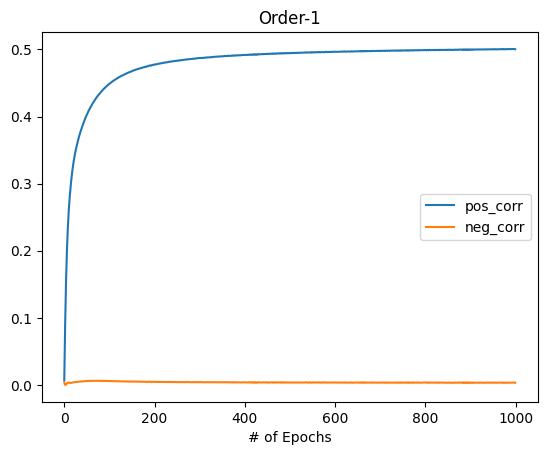

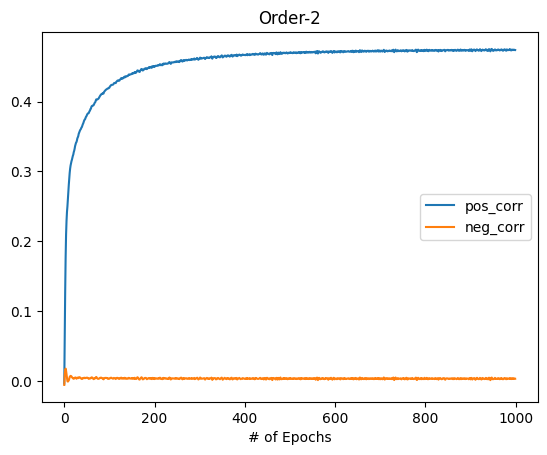

In [6]:
for t in range(1, num_layers+1):
    plt.plot(np.arange(num_epochs), corr_avg[t][0])
    plt.plot(np.arange(num_epochs), corr_avg[t][1])
    plt.legend(['pos_corr', 'neg_corr'])
    plt.xlabel('# of Epochs')
    plt.title(f'Order-{t}')
    plt.show()

In [7]:

SAVE_DIR = "/home/ubuntu/proj/code/axolotl_softprompt/data/cora"
if not os.path.exists(os.path.join(SAVE_DIR, relevance_type)):
    os.makedirs(os.path.join(SAVE_DIR, relevance_type))
embed = all_levels_embedding[relevance_type][0]
train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_textual_order0-{encoder_type}.pt'))
torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_textual_order0-{encoder_type}.pt'))
torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_textual_order0-{encoder_type}.pt'))

for i in range(1, num_layers+1):
    # save textual BERT embeddings
    embed = all_levels_embedding[relevance_type][i]
    train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'train_textual_order{i}-{encoder_type}.pt'))
    torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_textual_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_textual_order{i}-{encoder_type}.pt'))

    # save GNN embeddings
    embed = embeddings_mapping[i].detach().cpu()
    train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'train_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_{gnn}_order{i}-{encoder_type}.pt'))

In [8]:
'''SAVE_DIR = "/home/ubuntu/proj/code/axolotl_softprompt/data/pubmed"
if not os.path.exists(os.path.join(SAVE_DIR, relevance_type)):
    os.makedirs(os.path.join(SAVE_DIR, relevance_type))
embed = all_levels_embedding[relevance_type][0]
train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]
train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_textual_order0-{encoder_type}.pt'))
torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'test_textual_order0-{encoder_type}.pt'))

for i in range(1, num_layers+1):
    # save textual BERT embeddings
    embed = all_levels_embedding[relevance_type][i]
    train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_textual_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'test_textual_order{i}-{encoder_type}.pt'))

    # save GNN embeddings
    embed = embeddings_mapping[i].detach().cpu()
    train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'test_{gnn}_order{i}-{encoder_type}.pt'))'''

'SAVE_DIR = "/home/ubuntu/proj/code/axolotl_softprompt/data/pubmed"\nif not os.path.exists(os.path.join(SAVE_DIR, relevance_type)):\n    os.makedirs(os.path.join(SAVE_DIR, relevance_type))\nembed = all_levels_embedding[relevance_type][0]\ntrain_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]\ntrain_pos_tokens = train_pos_tokens.view(-1, 1, num_features)\ntest_pos_tokens = test_pos_tokens.view(-1, 1, num_features)\ntorch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f\'train_textual_order0-{encoder_type}.pt\'))\ntorch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f\'test_textual_order0-{encoder_type}.pt\'))\n\nfor i in range(1, num_layers+1):\n    # save textual BERT embeddings\n    embed = all_levels_embedding[relevance_type][i]\n    train_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(test_split)]\n    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)\n    tes